<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Полносвязные и свёрточные нейронные сети</b></h3>

В этом занятии вам предстоит потренироваться построению нейронных сетей с помощью библиотеки Pytorch. Делать мы это будем на нескольких датасетах.








In [1]:
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

# from sklearn.datasets import make_moons
# from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import TensorDataset, DataLoader

# sns.set(style="darkgrid", font_scale=1.4)

# Часть 1. Датасет moons

Давайте сгенерируем датасет и посмотрим на него!

In [ ]:
X, y = make_moons(n_samples=10000, random_state=42, noise=0.1)

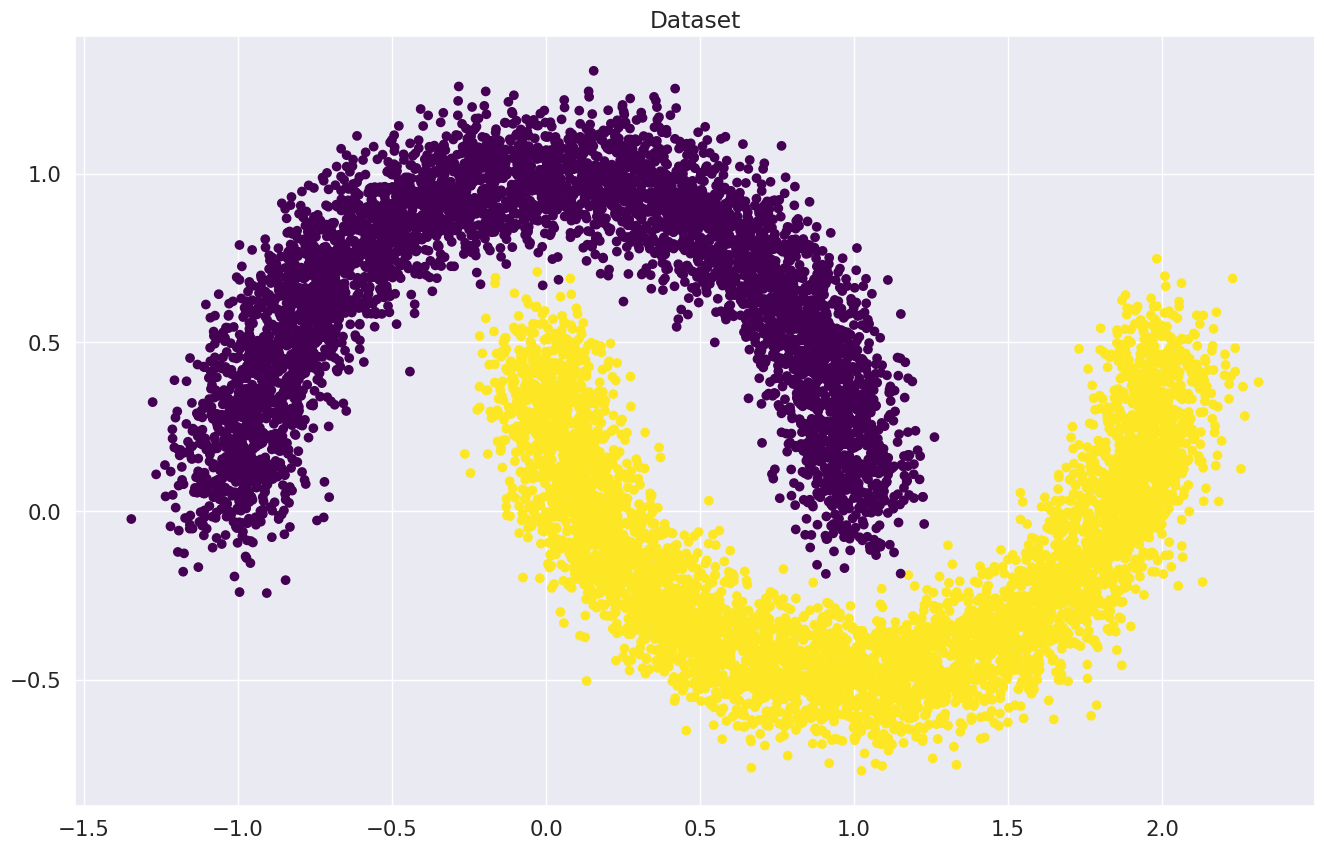

In [ ]:
plt.figure(figsize=(16, 10))
plt.title("Dataset")
plt.scatter(X[:, 0], X[:, 1], c=y, cmap="viridis")
plt.show()

Сделаем train/test split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

### Загрузка данных
В PyTorch загрузка данных как правило происходит налету (иногда датасеты не помещаются в оперативную память). Для этого используются две сущности `Dataset` и `DataLoader`.

1.   `Dataset` загружает каждый объект по отдельности.

2.   `DataLoader` группирует объекты из `Dataset` в батчи.

Так как наш датасет достаточно маленький мы будем использовать `TensorDataset`. Все, что нам нужно, это перевести из массива numpy в тензор с типом `torch.float32`.

### Задание. Создайте тензоры с обучающими и тестовыми данными

In [ ]:
X_train_t =  torch.tensor(X_train, dtype = torch.float32)
y_train_t =  torch.tensor(y_train, dtype = torch.float32)
X_val_t =  torch.tensor(X_val, dtype = torch.float32)
y_val_t =  torch.tensor(y_val, dtype = torch.float32)

Создаем `Dataset` и `DataLoader`.

In [ ]:
train_dataset = TensorDataset(X_train_t, y_train_t)
val_dataset = TensorDataset(X_val_t, y_val_t)
train_dataloader = DataLoader(train_dataset, batch_size=128)
val_dataloader = DataLoader(val_dataset, batch_size=128)

## Logistic regression is my profession

**Напоминание**
Давайте вспоним, что происходит в логистической регрессии. На входе у нас есть матрица объект-признак X и столбец-вектор $y$ – метки из $\{0, 1\}$ для каждого объекта. Мы хотим найти такую матрицу весов $W$ и смещение $b$ (bias), что наша модель $XW + b$ будет каким-то образом предсказывать класс объекта. Как видно на выходе наша модель может выдавать число в интервале от $(-\infty;\infty)$. Этот выход как правило называют "логитами" (logits). Нам необходимо перевести его на интервал от $[0;1]$ для того, чтобы он выдавал нам вероятность принадлежности объекта к кассу один, также лучше, чтобы эта функция была монотонной, быстро считалась, имела производную и на $-\infty$ имела значение $0$, а на $+\infty$ имела значение $1$. Такой класс функций называется сигмоидыю. Чаще всего в качестве сигмоида берут
$$
\sigma(x) = \frac{1}{1 + e^{-x}}.
$$

### Задание. Реализация логистической регрессии

Вам необходимо написать модуль на PyTorch реализующий $logits = XW + b$, где $W$ и $b$ – параметры (`nn.Parameter`) модели. Иначе говоря, здесь мы реализуем своими руками модуль `nn.Linear` (в этом пункте его использование запрещено). Инициализируйте веса нормальным распределением (`torch.randn`).

In [ ]:
class LinearRegression(nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True):
        super().__init__()
        self.weights = nn.Parameter(torch.randn(out_features,in_features))
        self.bias = bias
        if bias:
            self.bias_term = nn.Parameter(torch.randn(out_features))

    def forward(self, x):
        x =  torch.mm(x, self.weights.t())
        if self.bias:
            x += self.bias_term
        return x

In [ ]:
linear_regression = LinearRegression(2, 1)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(linear_regression.parameters(), lr=0.05)

**Вопрос 1.** Сколько обучаемых параметров у получившейся модели? Имеется в виду суммарное количество отдельных числовых переменных, а не количество тензоров.

In [ ]:
#YOUR CODE
num_params = sum(p.numel() for p in linear_regression.parameters() if p.requires_grad)
print(num_params)

3


### Train loop

Вот псевдокод, который поможет вам разобраться в том, что происходит во время обучения

```python
for epoch in range(max_epochs):  # <----------- итерируемся по датасету несколько раз
    for x_batch, y_batch in dataset:  # <------ итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
        optimizer.zero_grad()  # <------------- обуляем градиенты модели
        outp = model(x_batch)  # <------------- получаем "логиты" из модели
        loss = loss_func(outp, y_batch)  # <--- считаем "лосс" для логистической регрессии
        loss.backward()  # <------------------- считаем градиенты
        optimizer.step()  # <------------------ делаем шаг градиентного спуска
        if convergence:  # <------------------- в случае сходимости выходим из цикла
            break
```

В коде ниже добавлено логирование `accuracy` и `loss`.

### Задание. Реализация цикла обучения

In [ ]:
tol = 1e-3
losses = []
max_epochs = 100
prev_weights = torch.zeros_like(linear_regression.weights)
stop_it = False
for epoch in range(max_epochs):
    for it, (X_batch, y_batch) in enumerate(train_dataloader):
        optimizer.zero_grad()
        outp =  linear_regression(X_batch) # YOUR CODE. Use linear_regression to get outputs
        loss =  loss_function(outp,y_batch.unsqueeze(1)) # YOUR CODE. Compute loss
        loss.backward()
        losses.append(loss.detach().flatten()[0])
        optimizer.step()
        probabilities = torch.sigmoid(outp) # YOUR CODE. Compute probabilities
        preds = (probabilities > 0.5).type(torch.long)
        batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)

        if (it + epoch * len(train_dataloader)) % 100 == 0:
            print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
        current_weights = linear_regression.weights.detach().clone()
        if (prev_weights - current_weights).abs().max() < tol:
            print(f"\nIteration: {it + epoch * len(train_dataloader)}.Convergence. Stopping iterations.")
            stop_it = True
            break
        prev_weights = current_weights
    if stop_it:
        break

Iteration: 0
Batch accuracy: 0.5078125
Iteration: 100
Batch accuracy: 0.625
Iteration: 200
Batch accuracy: 0.7421875
Iteration: 300
Batch accuracy: 0.8046875
Iteration: 400
Batch accuracy: 0.7578125
Iteration: 500
Batch accuracy: 0.859375
Iteration: 600
Batch accuracy: 0.8359375
Iteration: 700
Batch accuracy: 0.796875
Iteration: 800
Batch accuracy: 0.8125
Iteration: 900
Batch accuracy: 0.8125

Iteration: 936.Convergence. Stopping iterations.


**Вопрос 2.** Сколько итераций потребовалось, чтобы алгоритм сошелся?

**Ответ:** 936

### Визуализируем результаты

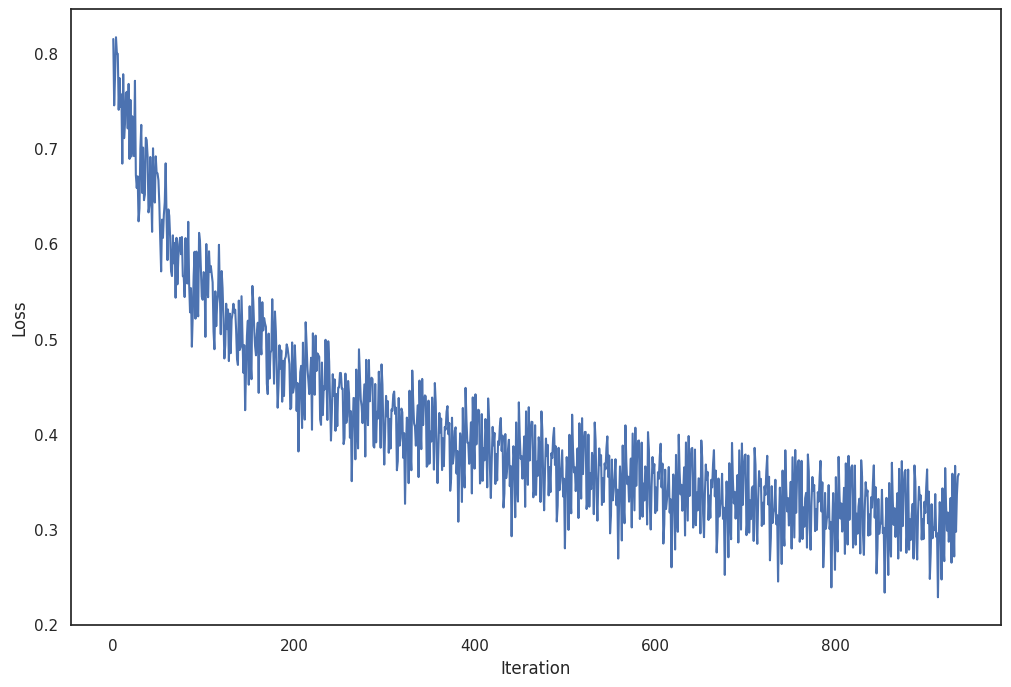

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

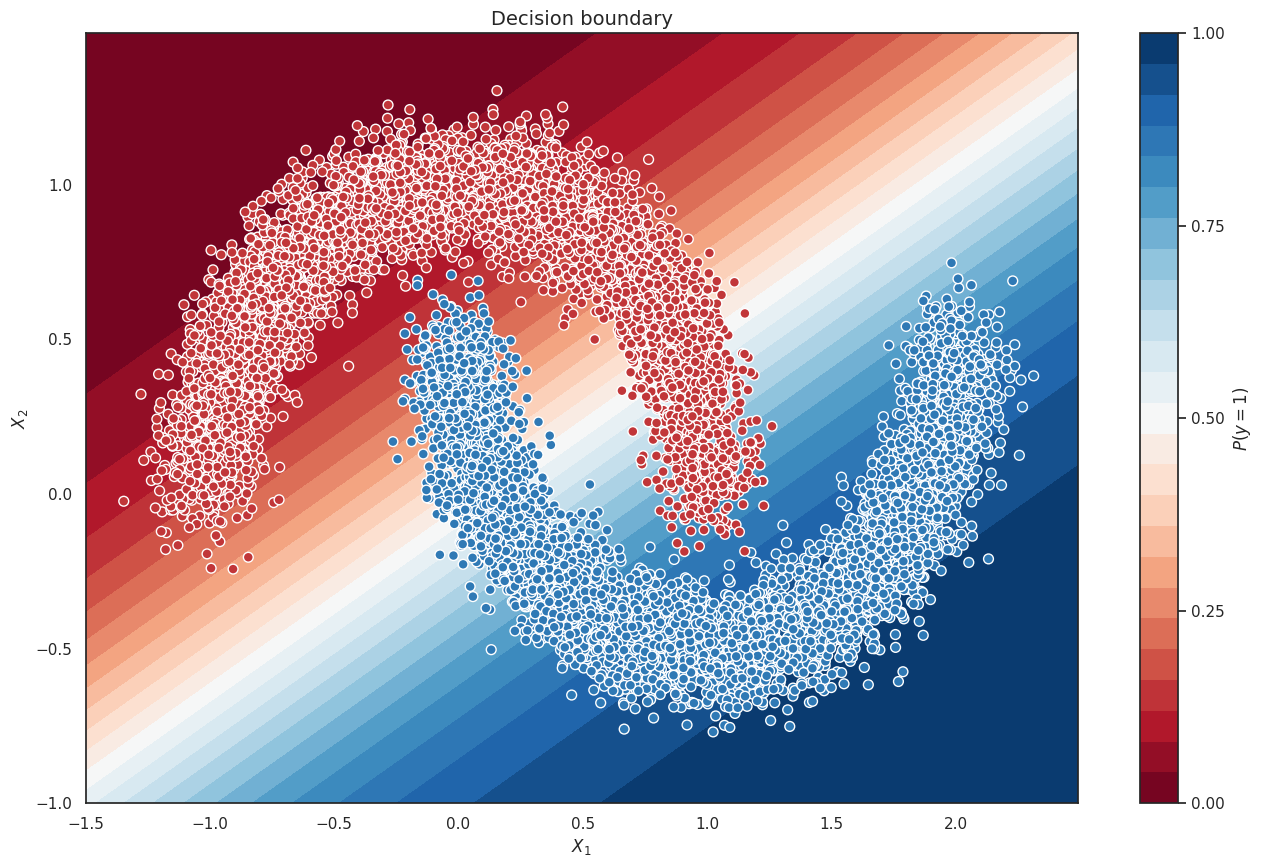

In [ ]:
import numpy as np

sns.set(style="white")

xx, yy = np.mgrid[-1.5:2.5:.01, -1.:1.5:.01]
grid = np.c_[xx.ravel(), yy.ravel()]
batch = torch.from_numpy(grid).type(torch.float32)
with torch.no_grad():
    probs = torch.sigmoid(linear_regression(batch).reshape(xx.shape))
    probs = probs.numpy().reshape(xx.shape)

f, ax = plt.subplots(figsize=(16, 10))
ax.set_title("Decision boundary", fontsize=14)
contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu",
                      vmin=0, vmax=1)
ax_c = f.colorbar(contour)
ax_c.set_label("$P(y = 1)$")
ax_c.set_ticks([0, .25, .5, .75, 1])

ax.scatter(X[100:,0], X[100:, 1], c=y[100:], s=50,
           cmap="RdBu", vmin=-.2, vmax=1.2,
           edgecolor="white", linewidth=1)

ax.set(xlabel="$X_1$", ylabel="$X_2$")
plt.show()

### Задание. Реализуйте predict и посчитайте accuracy на test.

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = []
    # predictions = torch.tensor([], dtype=torch.long)  # Initialize an empty tensor for predictions
    for x_batch, _ in dataloader:
        preds = model(x_batch)
        probabilities = torch.sigmoid(preds)  # Convert the outputs to probabilities
        preds = (probabilities > 0.5).type(torch.long)  # Binarize the probabilities to obtain predictions
        predictions.extend(preds.flatten().tolist())
        # predictions = torch.cat((predictions, preds.flatten()), dim=0)  # Concatenate the predictions
    # return predictions.numpy()  # Convert the tensor of predictions to a numpy array
    return np.array(predictions)

In [ ]:
from sklearn.metrics import accuracy_score

# YOUR CODE. Compute total accuracy
y_true = torch.FloatTensor()
for (X_batch_test, y_batch_test) in val_dataloader:
  y_true = torch.cat((y_true, y_batch_test), dim=0)
  # print(y_batch.shape)
# y_true.shape
accuracy_score(y_true.detach().numpy(), predict(val_dataloader, linear_regression))

0.8552

**Вопрос 3**

Какое `accuracy` получается после обучения?

**Ответ:** 0.85

# Часть 2. Датасет MNIST
Датасет MNIST содержит рукописные цифры. Загрузим датасет и создадим DataLoader-ы. Пример можно найти в семинаре по полносвязным нейронным сетям.

In [2]:
import os
from torchvision.datasets import MNIST
from torchvision import transforms as tfs


data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5))
])

# install for train and test
root = './'
train_dataset = MNIST(root, train=True,  transform=data_tfs, download=True)
val_dataset  = MNIST(root, train=False, transform=data_tfs, download=True)

batch_size = 128

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True) # YOUR CODE GOES HERE
valid_dataloader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True) # YOUR CODE GOES HERE

In [15]:
image, label = train_dataset[0]
print(image.shape)

torch.Size([1, 28, 28])


## Часть 2.1. Полносвязные нейронные сети
Сначала решим MNIST с помощью полносвязной нейронной сети.

In [26]:
class Identical(nn.Module):
    def forward(self, x):
        return x

### Задание. Простая полносвязная нейронная сеть

Создайте полносвязную нейронную сеть с помощью класса Sequential. Сеть состоит из:
* Уплощения матрицы в вектор (nn.Flatten);
* Двух скрытых слоёв из 128 нейронов с активацией nn.ELU;
* Выходного слоя с 10 нейронами.

Задайте лосс для обучения (кросс-энтропия).


In [27]:
activation = nn.ELU

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28,128),
    nn.ELU(),
    nn.Linear(128,128),
    nn.ELU(),
    nn.Linear(128,10)
    #YOUR CODE. Add layers to your sequential class
)

In [28]:
criterion = torch.nn.CrossEntropyLoss() #YOUR CODE. Select a loss function
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Train loop (seriously)

Давайте разберемся с кодом ниже, который подойдет для 90% задач в будущем.


```python
for epoch in range(max_epochs):  # <--------------- итерируемся по датасету несколько раз
    for k, dataloader in loaders.items():  # <----- несколько dataloader для train / valid / test
        for x_batch, y_batch in dataloader:  # <--- итерируемся по датасету. Так как мы используем SGD а не GD, то берем батчи заданного размера
            if k == "train":
                model.train()  # <------------------ переводим модель в режим train
                optimizer.zero_grad()  # <--------- обнуляем градиенты модели
                outp = model(x_batch)
                loss = criterion(outp, y_batch) # <-считаем "лосс" для логистической регрессии
                loss.backward()  # <--------------- считаем градиенты
                optimizer.step()  # <-------------- делаем шаг градиентного спуска
            else:  # <----------------------------- test/eval
                model.eval()  # <------------------ переводим модель в режим eval
                with torch.no_grad():  # <--------- НЕ считаем градиенты
                    outp = model(x_batch)  # <------------- получаем "логиты" из модели
            count_metrics(outp, y_batch)  # <-------------- считаем метрики
```

### Задание. Дополните цикл обучения.

In [51]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            if k == "train":
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                 model.eval()
                 with torch.no_grad():
                  outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum() # YOUR CODE GOES HERE
            all = y_batch.size(0) # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                # YOUR CODE. Calculate gradients and make a step of your optimizer
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)


Epoch: 1
Loader: train. Accuracy: 0.9874131944444444
Loader: valid. Accuracy: 0.9723557692307693
Epoch: 2
Loader: train. Accuracy: 0.9875968215811965
Loader: valid. Accuracy: 0.9720552884615384
Epoch: 3
Loader: train. Accuracy: 0.9890992254273504
Loader: valid. Accuracy: 0.97265625
Epoch: 4
Loader: train. Accuracy: 0.9896334134615384
Loader: valid. Accuracy: 0.9682491987179487
Epoch: 5
Loader: train. Accuracy: 0.9901676014957265
Loader: valid. Accuracy: 0.9723557692307693
Epoch: 6
Loader: train. Accuracy: 0.991386217948718
Loader: valid. Accuracy: 0.9627403846153846
Epoch: 7
Loader: train. Accuracy: 0.9914029113247863
Loader: valid. Accuracy: 0.9642427884615384
Epoch: 8
Loader: train. Accuracy: 0.9930388621794872
Loader: valid. Accuracy: 0.9630408653846154
Epoch: 9
Loader: train. Accuracy: 0.9920372596153846
Loader: valid. Accuracy: 0.9659455128205128
Epoch: 10
Loader: train. Accuracy: 0.9936732104700855
Loader: valid. Accuracy: 0.9725560897435898


### Задание. Протестируйте разные функции активации.
Попробуйте разные функции активации. Для каждой функции активации посчитайте массив validation accuracy. Лучше реализовать это в виде функции, берущей на вход активацию и получающей массив из accuracies.

In [22]:
elu_accuracy = accuracy["valid"]

In [30]:
class CustomModel(nn.Module):
    def __init__(self, activation):
        super(CustomModel, self).__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            activation,
            nn.Linear(128, 128),
            activation,
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.layers(x)

def train_and_validate(model, dataloaders, criterion, optimizer, num_epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_accuracy = []
    valid_accuracy = []

    for epoch in range(num_epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_corrects = 0
            running_total = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_corrects += torch.sum(preds == labels.data)
                running_total += labels.size(0)

            epoch_acc = running_corrects.double() / running_total

            if phase == 'train':
                train_accuracy.append(epoch_acc)
            else:
                valid_accuracy.append(epoch_acc)

    return train_accuracy, valid_accuracy

def test_activation_function(activation_function_name: str, dataloaders):
    activations = {'Identical': nn.Identity(),
                   'ReLU': nn.ReLU(),
                   'LeakyReLU': nn.LeakyReLU(),
                   'Sigmoid': nn.Sigmoid(),
                   'Tanh': nn.Tanh(),
                   'ELU': nn.ELU()}

    print(f"Testing {activation_function_name} activation function...")
    model = CustomModel(activations[activation_function_name])
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    accuracy = train_and_validate(model, dataloaders, criterion, optimizer)

    return accuracy

In [31]:
plain_accuracy = test_activation_function("Identical", loaders)
relu_accuracy = test_activation_function("ReLU", loaders) #YOUR CODE
leaky_relu_accuracy = test_activation_function("LeakyReLU", loaders) #YOUR CODE
elu_accuracy = test_activation_function("ELU", loaders)

Testing Identical activation function...
Testing ReLU activation function...
Testing LeakyReLU activation function...
Testing ELU activation function...


### Accuracy
Построим график accuracy/epoch для каждой функции активации.

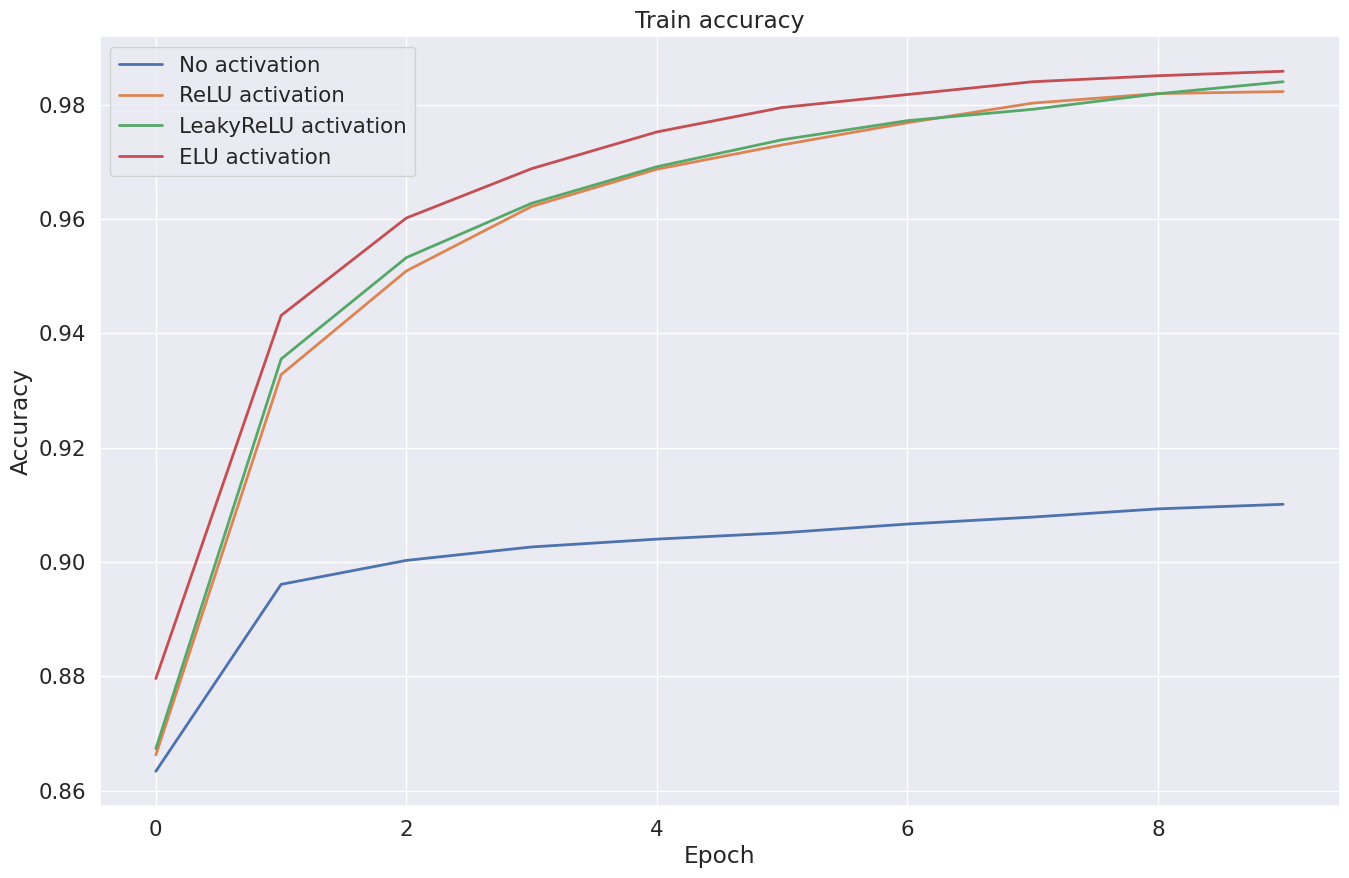

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Train accuracy")

# Extract just the training accuracies (the first list of each accuracy type)
train_plain_accuracy = [t.cpu().numpy() for t in plain_accuracy[0]]
train_relu_accuracy = [t.cpu().numpy() for t in relu_accuracy[0]]
train_leaky_relu_accuracy = [t.cpu().numpy() for t in leaky_relu_accuracy[0]]
train_elu_accuracy = [t.cpu().numpy() for t in elu_accuracy[0]]

# Define the x-axis range based on the training accuracy length
max_epochs = len(train_plain_accuracy)

plt.plot(range(max_epochs), train_plain_accuracy, label="No activation", linewidth=2)
plt.plot(range(max_epochs), train_relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), train_leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), train_elu_accuracy, label="ELU activation", linewidth=2)

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [53]:
len(plain_accuracy_flat)

20

In [54]:
plain_accuracy_flat

[array(0.86338141),
 array(0.89608373),
 array(0.90027377),
 array(0.90262754),
 array(0.90399639),
 array(0.90509816),
 array(0.90663395),
 array(0.90785256),
 array(0.90928819),
 array(0.91008948),
 array(0.89122596),
 array(0.89833734),
 array(0.89813702),
 array(0.90164263),
 array(0.90154247),
 array(0.90134215),
 array(0.90114183),
 array(0.90244391),
 array(0.90294471),
 array(0.90404647)]

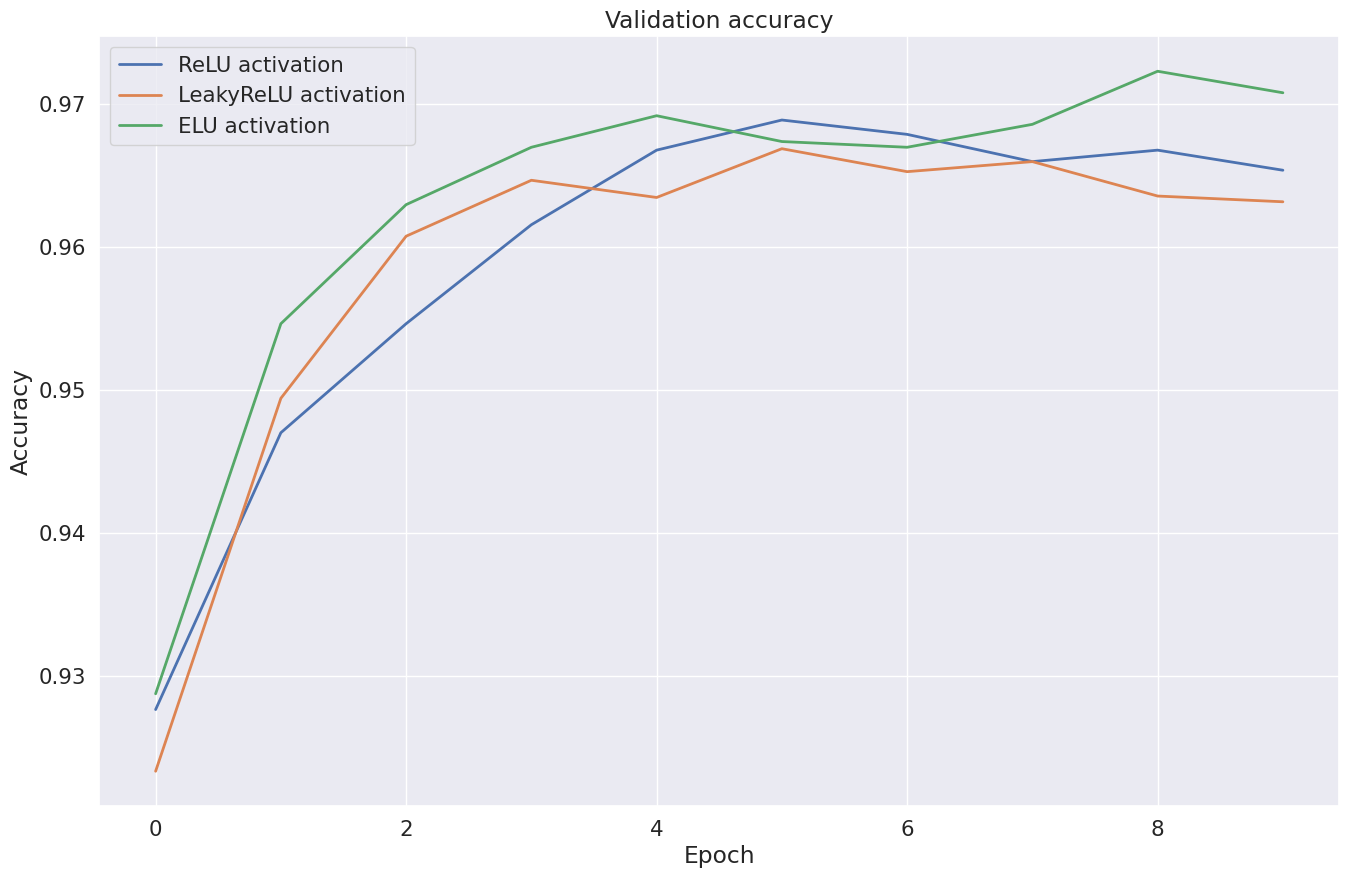

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid", font_scale=1.4)

plt.figure(figsize=(16, 10))
plt.title("Validation accuracy")

# Make sure to move the tensors to CPU and convert to numpy arrays
valid_relu_accuracy = [t.cpu().numpy() for t in relu_accuracy[1]]
valid_leaky_relu_accuracy = [t.cpu().numpy() for t in leaky_relu_accuracy[1]]
valid_elu_accuracy = [t.cpu().numpy() for t in elu_accuracy[1]]

# Define the x-axis range based on the length of the validation accuracy list
max_epochs = len(valid_relu_accuracy)  # Assuming all lists are the same length

plt.plot(range(max_epochs), valid_relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), valid_leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), valid_elu_accuracy, label="ELU activation", linewidth=2)

plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

In [63]:
print(np.max(train_elu_accuracy))

0.9858607104700856


**Вопрос 4.** Какая из активаций показала наивысший `accuracy` к концу обучения?

**Ответ:** ELU 0.98

## Часть 2.2 Сверточные нейронные сети

### Ядра
Сначала немного поработам с самим понятием ядра свёртки.

In [ ]:
!wget https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg -O sample_photo.jpg

--2023-11-05 09:01:21--  https://img.the-village.kz/the-village.com.kz/post-cover/5x5-I6oiwjmq79dMCZMEbA-default.jpg
Resolving img.the-village.kz (img.the-village.kz)... 5.9.226.237
Connecting to img.the-village.kz (img.the-village.kz)|5.9.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 49337 (48K) [image/jpeg]
Saving to: ‘sample_photo.jpg’

sample_photo.jpg    100%[===================>]  48.18K   160KB/s    in 0.3s    

2023-11-05 09:01:22 (160 KB/s) - ‘sample_photo.jpg’ saved [49337/49337]



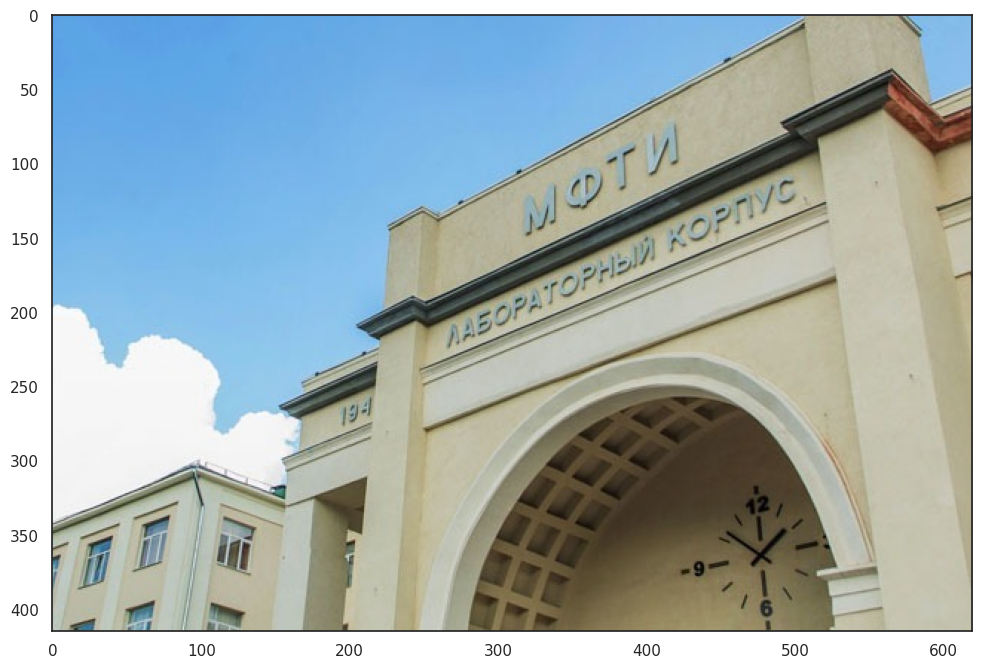

In [ ]:
import cv2
sns.set(style="white")
img = cv2.imread("sample_photo.jpg")
RGB_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 8))
plt.imshow(RGB_img)
plt.show()

Попробуйте посмотреть как различные свертки влияют на фото. Например, попробуйте
A)
```
[0, 0, 0],
[0, 1, 0],
[0, 0, 0]
```
Б)
```
[0, 1, 0],
[0, -2, 0],
[0, 1, 0]
```
В)
```
[0, 0, 0],
[1, -2, 1],
[0, 0, 0]
```
Г)
```
[0, 1, 0],
[1, -4, 1],
[0, 1, 0]
```
Д)
```
[0, -1, 0],
[-1, 5, -1],
[0, -1, 0]
```
Е)
```
[0.0625, 0.125, 0.0625],
[0.125, 0.25, 0.125],
[0.0625, 0.125, 0.0625]
```

Не стесняйтесь пробовать свои варианты!

In [ ]:
img_t = torch.from_numpy(RGB_img).type(torch.float32).unsqueeze(0)
kernel = torch.tensor([
    [0, 0, 0],
    [1, -2, 1],
    [0, 0, 0]
]).reshape(1, 1, 3, 3).type(torch.float32)

kernel = kernel.repeat(3, 3, 1, 1)
img_t = img_t.permute(0, 3, 1, 2)  # [BS, H, W, C] -> [BS, C, H, W]
img_t = nn.ReflectionPad2d(1)(img_t)  # Pad Image for same output size

result = F.conv2d(img_t, kernel)[0]  #

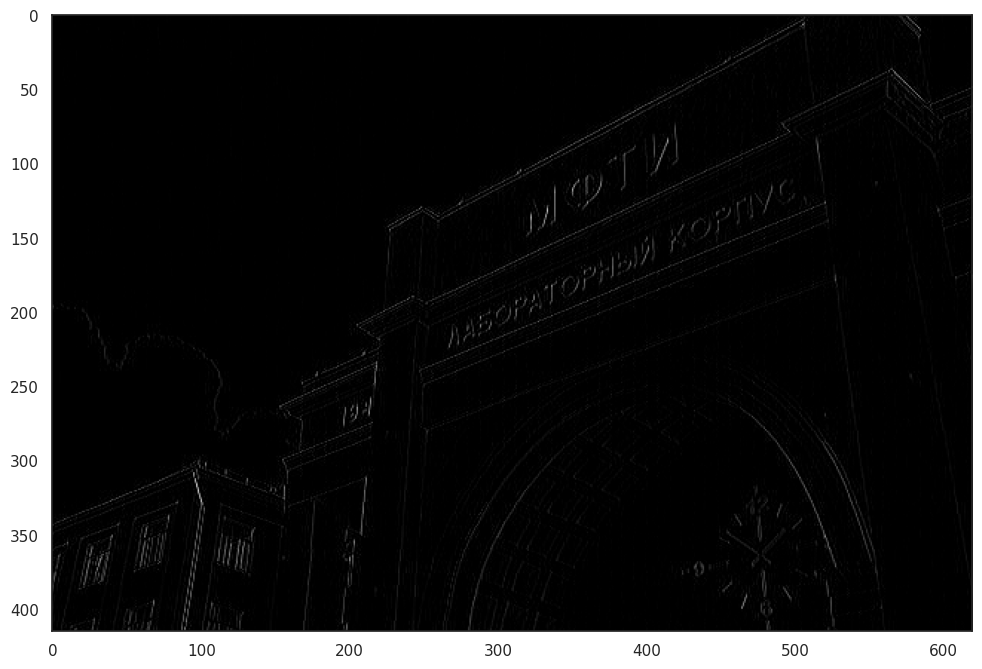

In [ ]:
plt.figure(figsize=(12, 8))
result_np = result.permute(1, 2, 0).numpy() / 256 / 3

plt.imshow(result_np)
plt.show()

**Вопрос 5.** Как можно описать действия ядер, приведенных выше? Сопоставьте для каждой буквы число.

1) Размытие

2) Увеличение резкости

3) Тождественное преобразование

4) Выделение вертикальных границ

5) Выделение горизонтальных границ

6) Выделение границ

**Ответ:**
1е 2д 3а 4в 5б 6г

### Задание. Реализуйте LeNet

Если мы сделаем параметры сверток обучаемыми, то можем добиться хороших результатов для задач компьютерного зрения. Реализуйте архитектуру LeNet, предложенную еще в 1998 году!
На этот раз используйте модульную структуру (без помощи класса Sequential).

Наша нейронная сеть будет состоять из
* Свёртки 3x3 (1 карта на входе, 6 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Свёртки 3x3 (6 карт на входе, 16 на выходе) с активацией ReLU;
* MaxPooling-а 2x2;
* Уплощения (nn.Flatten);
* Полносвязного слоя со 120 нейронами и активацией ReLU;
* Полносвязного слоя с 84 нейронами и активацией ReLU;
* Выходного слоя из 10 нейронов.




In [15]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square conv kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool1 = nn.MaxPool2d(kernel_size = 2) #YOUR CODE
        self.conv2 = nn.Conv2d(6,16,3) #YOUR CODE
        self.pool2 = nn.MaxPool2d(kernel_size = 2) #YOUR CODE
        self.fc1 = nn.Linear(16*5*5, 120) #YOUR CODE
        self.fc2 = nn.Linear(120,84) #YOUR CODE
        self.fc3 = nn.Linear(84,10) #YOUR CODE

    def forward(self, x):
        x = F.relu(self.conv1(x))  # Convolutional layer 1 with ReLU activation
        x = self.pool1(x)  # Max pooling layer 1
        x = F.relu(self.conv2(x))  # Convolutional layer 2 with ReLU activation
        x = self.pool2(x)  # Max pooling layer 2
        # print(x.shape)
        # batch_size = x.size(0)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))  # Fully connected layer 1 with ReLU activation
        x = F.relu(self.fc2(x))  # Fully connected layer 2 with ReLU activation
        x = self.fc3(x)  # Fully connected layer 3
        return x

In [16]:
model = LeNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

loaders = {"train": train_dataloader, "valid": valid_dataloader}

### Задание. Обучите CNN
Используйте код обучения, который вы написали для полносвязной нейронной сети.

In [17]:
max_epochs = 10
accuracy = {"train": [], "valid": []}
for epoch in range(max_epochs):
    for k, dataloader in loaders.items():
        epoch_correct = 0
        epoch_all = 0
        for x_batch, y_batch in dataloader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            if k == "train":
                 # YOUR CODE. Set model to ``train`` mode and calculate outputs. Don't forget zero_grad!
                 model.train()
                 optimizer.zero_grad()
                 outp = model(x_batch)
            else:
                 # YOUR CODE. Set model to ``eval`` mode and calculate outputs
                 model.eval()
                 with torch.no_grad():
                  outp = model(x_batch)
            preds = outp.argmax(-1)
            correct = (preds == y_batch).sum() # YOUR CODE GOES HERE
            all = y_batch.size(0) # YOUR CODE GOES HERE
            epoch_correct += correct.item()
            epoch_all += all
            if k == "train":
                loss = criterion(outp, y_batch)
                # YOUR CODE. Calculate gradients and make a step of your optimizer
                loss.backward()
                optimizer.step()
        if k == "train":
            print(f"Epoch: {epoch+1}")
        print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
        accuracy[k].append(epoch_correct/epoch_all)

Epoch: 1
Loader: train. Accuracy: 0.8729467147435898
Loader: valid. Accuracy: 0.9596354166666666
Epoch: 2
Loader: train. Accuracy: 0.9668135683760684
Loader: valid. Accuracy: 0.9700520833333334
Epoch: 3
Loader: train. Accuracy: 0.9776809561965812
Loader: valid. Accuracy: 0.9770633012820513
Epoch: 4
Loader: train. Accuracy: 0.9831229967948718
Loader: valid. Accuracy: 0.9815705128205128
Epoch: 5
Loader: train. Accuracy: 0.986061030982906
Loader: valid. Accuracy: 0.9830729166666666
Epoch: 6
Loader: train. Accuracy: 0.989082532051282
Loader: valid. Accuracy: 0.9849759615384616
Epoch: 7
Loader: train. Accuracy: 0.9908353365384616
Loader: valid. Accuracy: 0.985176282051282
Epoch: 8
Loader: train. Accuracy: 0.9924879807692307
Loader: valid. Accuracy: 0.9847756410256411
Epoch: 9
Loader: train. Accuracy: 0.9935897435897436
Loader: valid. Accuracy: 0.9839743589743589
Epoch: 10
Loader: train. Accuracy: 0.9945412660256411
Loader: valid. Accuracy: 0.9825721153846154


In [18]:
lenet_accuracy = accuracy["valid"]

Сравним с предыдущем пунктом

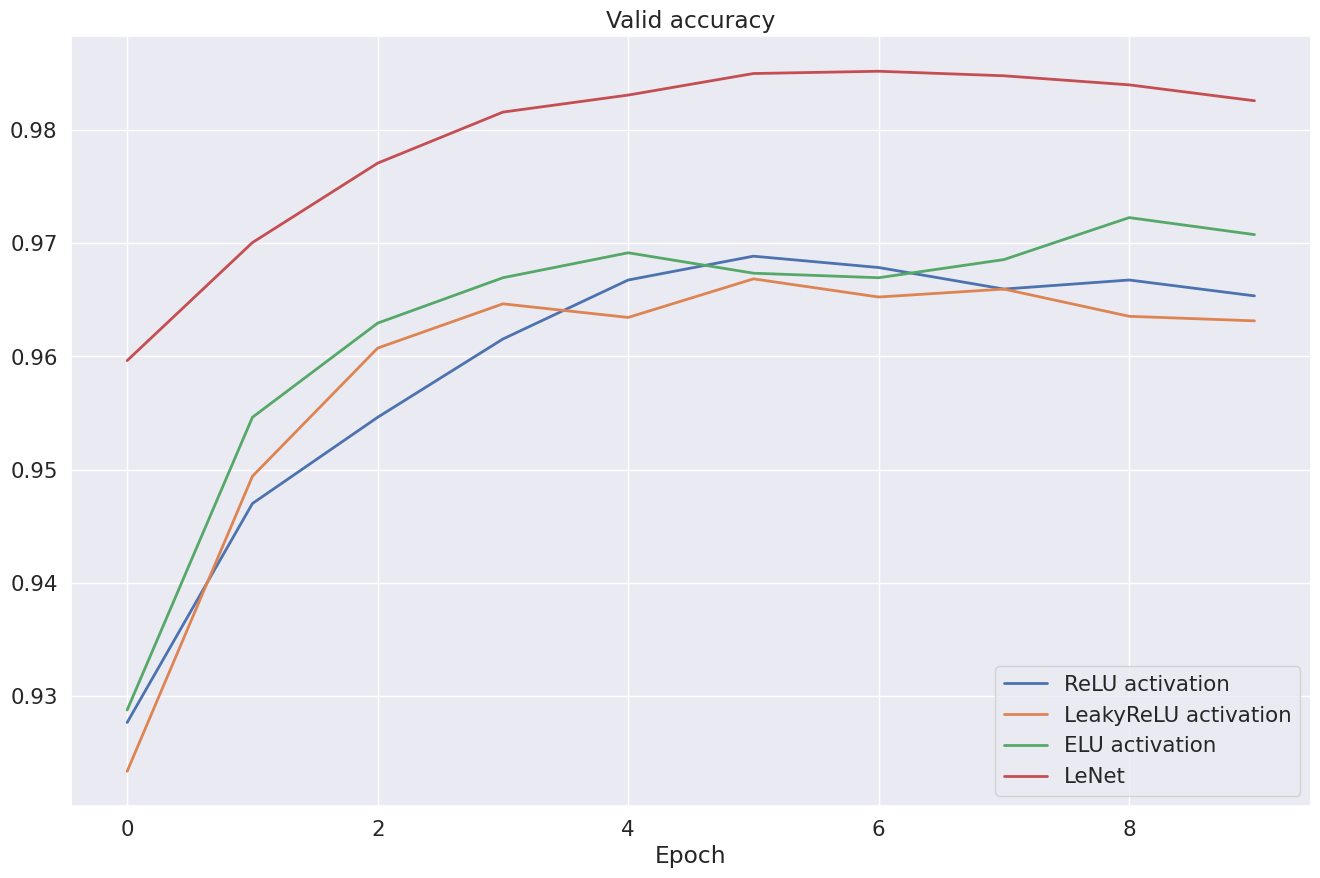

In [59]:
plt.figure(figsize=(16, 10))
plt.title("Valid accuracy")
plt.plot(range(max_epochs), valid_relu_accuracy, label="ReLU activation", linewidth=2)
plt.plot(range(max_epochs), valid_leaky_relu_accuracy, label="LeakyReLU activation", linewidth=2)
plt.plot(range(max_epochs), valid_elu_accuracy, label="ELU activation", linewidth=2)
plt.plot(range(max_epochs), lenet_accuracy, label="LeNet", linewidth=2)
plt.legend()
plt.xlabel("Epoch")
plt.show()

**Вопрос 6**
Какое `accuracy` получается после обучения с точностью до двух знаков после запятой?

**Ответ:** 0.96

In [60]:
print(np.mean(lenet_accuracy[0]))

0.9596354166666666
